Lab #4 ,
Arend Matthew, aw3146

1. Run a simple regression, with at least two Xs in it, and interpret your results. (Did the results fit your expectations? Why? Why not?)

2. Add an interaction term to that model that you think might moderate the original relationship between X1 and X2. Explain why you think an interaction might be present and in what direction it would work. Explain your results. Did it work out? Yes? No?

3. Extra Credit: Plot the relationship found in the interaction
    
    

In [1]:
# importing relevant modules...

from __future__ import division
import pandas as pd
import numpy as np
import re, os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns #os.system('pip install seaborn')
from scipy import stats
import pycountry_convert as pc #os.system("pip install pycountry-convert")
from colour import Color #os.system('pip install colour')

# defining helper functions for later in my code

def printurn(x):
    print(x)
    return(x)

def recode_onehot_if(s='CHILDRENS COAT', pattern='CHILDREN', as_float=True):
    result = '1' if pattern in str(s) else '0'
    result = float(result) if as_float else result
    return(result)

def recode_onehot_if_greater_than(number=15, greater_than=10, as_float=True):
    result = '1' if float(number)>greater_than else '0'
    result = float(result) if as_float else result
    return(result)

def check_color(color):
    try:
        Color(color)
        return(True)
    except ValueError as e:
        return(False)

def extract_color(pdcolumn):
    pdcolumn = pd.Series(pdcolumn.copy()) if type(pdcolumn)==str else pd.Series(pdcolumn) if type(pdcolumn)==list else pdcolumn
    newcolumn = pdcolumn.copy().apply(lambda s: ' '.join([i for i in str(s).split(' ') if check_color(i)]))
    return(newcolumn)

def compute_percentage(x, my_crosstab):
      pct = float(x/my_crosstab['count'].sum()) * 100
      return round(pct, 2)

In [2]:
os.system('kaggle datasets download alexanderbader/forbes-billionaires-of-2021-20/forbes_billionaires.csv')
import zipfile 
archive = zipfile.ZipFile('forbes-billionaires-of-2021-20.zip')
filename = archive.filelist[0].filename
xlfile = archive.open(filename)
df = pd.read_csv(xlfile)

In [3]:
df = df.assign(education_status = df.Education.str.replace('.*(Drop Out|Bachelor|Master|Doctor|High School).*', '\\1', regex=True),
               high_ed_grad = df.Education.apply(lambda s: 'Higher Education Grad' if s in [''] else 'No Higher Education Grad'),
               relationship_or_single = df.Status.astype(str).replace({'(Widowed$|Separated|Single|Divorced).*':'Single', '(Widowed,|In|Married|Engaged|Remarried).*':'In Relationship'}, regex=True).replace({'nan': np.nan}),
              )
# print(df.Status.value_counts()); # print(df.relationship_or_single.value_counts()); # print(df.education_status.value_counts())
df

,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,education_status,high_ed_grad,relationship_or_single
0,Jeff Bezos,177.0,United States,Amazon,1,57.0,"Seattle, Washington",United States,In Relationship,4.0,"Bachelor of Arts/Science, Princeton University",True,Bachelor,No Higher Education Grad,In Relationship
1,Elon Musk,151.0,United States,"Tesla, SpaceX",2,49.0,"Austin, Texas",United States,In Relationship,7.0,"Bachelor of Arts/Science, University of Pennsy...",True,Bachelor,No Higher Education Grad,In Relationship
2,Bernard Arnault & family,150.0,France,LVMH,3,72.0,"Paris, France",France,Married,5.0,"Bachelor of Arts/Science, Ecole Polytechnique ...",False,Bachelor,No Higher Education Grad,In Relationship
3,Bill Gates,124.0,United States,Microsoft,4,65.0,"Medina, Washington",United States,Divorced,3.0,"Drop Out, Harvard University",True,Drop Out,No Higher Education Grad,Single
4,Mark Zuckerberg,97.0,United States,Facebook,5,36.0,"Palo Alto, California",United States,Married,2.0,"Drop Out, Harvard University",True,Drop Out,No Higher Education Grad,In Relationship
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,Daniel Yong Zhang,1.0,China,e-commerce,2674,49.0,"Hangzhou, China",China,NaN,NaN,NaN,True,NaN,No Higher Education Grad,NaN
2751,Zhang Yuqiang,1.0,China,Fiberglass,2674,65.0,"Tongxiang, China",China,NaN,NaN,NaN,True,NaN,No Higher Education Grad,NaN
2752,Zhao Meiguang,1.0,China,gold mining,2674,58.0,"Jilin, China",China,NaN,NaN,NaN,True,NaN,No Higher Education Grad,NaN
2753,Zhong Naixiong,1.0,China,conglomerate,2674,58.0,"Foshan, China",China,NaN,NaN,NaN,True,NaN,No Higher Education Grad,NaN


In [335]:
df.columns
df.relationship_or_single
pd.DataFrame(df.value_counts())

,,,,,,,,,,,,,,,,,,,,0
Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,education_status,high_ed_grad,relationship_or_single,youth,points,revyouth,fake_age,fake_networth,
Abhay Vakil & family,4.6,India,paints,622,70.0,"Mumbai, India",India,Married,3.0,"Bachelor of Arts/Science, Bombay University; Bachelor of Arts/Science, Syracuse University",False,Bachelor,No Higher Education Grad,In Relationship,20.0,2052,3.0,70.0,4.6,1
Pablo Legorreta,2.9,United States,investments,1064,57.0,"Sag Harbor, New York",United States,Married,2.0,"Bachelor of Science in Engineering, Universidad Iberoamericana",True,Bachelor,No Higher Education Grad,In Relationship,21.0,1610,2.0,57.0,2.9,1
Nik Storonsky,1.2,United Kingdom,fintech,2378,36.0,"London, United Kingdom",United Kingdom,Married,2.0,"Master of Science, Moscow Institute of Physics and Technology",True,Master,No Higher Education Grad,In Relationship,21.0,296,2.0,436.0,1.2,1
Niraj Shah,3.6,United States,online retail,831,47.0,"Boston, Massachusetts",United States,Married,2.0,"Bachelor of Science in Engineering, Cornell University",True,Bachelor,No Higher Education Grad,In Relationship,21.0,1843,2.0,47.0,3.6,1
Niranjan Hiranandani,1.6,India,real estate,1931,71.0,"Mumbai, India",India,Married,2.0,"Bachelor of Arts/Science, University of Bombay",True,Bachelor,No Higher Education Grad,In Relationship,21.0,743,2.0,71.0,1.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Henry Engelhardt,1.7,United States,insurance,1833,63.0,"Cardiff, United Kingdom",United States,Married,4.0,"Master of Business Administration, INSEAD; Bachelor of Arts/Science, University of Michigan",True,Bachelor,No Higher Education Grad,In Relationship,19.0,841,4.0,63.0,1.7,1
Henry Kravis,7.3,United States,private equity,344,77.0,"New York, New York",United States,Married,2.0,"Bachelor of Arts/Science, Claremont McKenna College; Master of Business Administration, Columbia Business School",True,Master,No Higher Education Grad,In Relationship,21.0,2330,2.0,77.0,7.3,1
"Henry Nicholas, III.",5.4,United States,semiconductors,520,61.0,"Newport Coast, California",United States,Divorced,3.0,"Bachelor of Arts/Science, University of California, Los Angeles; Doctorate, University of California, Los Angeles; Master of Science, University of California, Los Angeles",True,Master,No Higher Education Grad,Single,20.0,2154,3.0,61.0,5.4,1


In [144]:
df['youth'] = abs(df['Children'] - max(df.Children))
print(df.Children.dropna())
print(df.youth.dropna())
df['points'] = abs(df['Rank'] - max(df.Rank))
df['revyouth'] = abs(df['youth'] - max(df.Children))


0       4.0
1       7.0
2       5.0
3       3.0
4       2.0
       ... 
2737    4.0
2738    2.0
2742    2.0
2743    2.0
2746    3.0
Name: Children, Length: 1552, dtype: float64
0       19.0
1       16.0
2       18.0
3       20.0
4       21.0
        ... 
2737    19.0
2738    21.0
2742    21.0
2743    21.0
2746    20.0
Name: youth, Length: 1552, dtype: float64


In [325]:
# # AREND CUSTOM (bc I personally hate downloading data files to my disk...):
USE_GSS=True
if USE_GSS: # I'm not using GSS data for this lab, but if we wanted to, then we could grab the data straight from a URL (demo below).
    # try:
    #     import gssapi
    # except:
    #     os.system('pip install gssapi'); import gssapi
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen # or: requests.get(url).content
    resp = urlopen('http://gss.norc.org/documents/stata/1991_stata.zip')
    zipfile = ZipFile(BytesIO(resp.read()))
    dtafile = zipfile.namelist()[0]
    print(dtafile) # ['GSS2006.dta']
    gss = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
    
print(sorted(gss.columns[gss.columns.str.contains('music|^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|wrkstat|class')].tolist()))
gss = gss.copy()[gss.columns[gss.columns.str.contains('^age$|^sex$|gender$|^race|^educ$|classicl|country|wwwclass')]]
print(gss)

# # AREND CUSTOM (bc I personally hate downloading data files to my disk...):
USE_GSS=True
if USE_GSS: # I'm not using GSS data for this lab, but if we wanted to, then we could grab the data straight from a URL (demo below).
    # try:
    #     import gssapi
    # except:
    #     os.system('pip install gssapi'); import gssapi
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen # or: requests.get(url).content
    resp = urlopen('http://gss.norc.org/documents/stata/1993_stata.zip')
    zipfile = ZipFile(BytesIO(resp.read()))
    dtafile = zipfile.namelist()[0]
    print(dtafile) # ['GSS2006.dta']
    gss = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
    
print(sorted(gss.columns[gss.columns.str.contains('music|^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|wrkstat|class')].tolist()))
gss = gss.copy()[gss.columns[gss.columns.str.contains('^age$|^sex$|gender$|^race|^educ$|classicl|country|wwwclass')]]
print(gss)

# # AREND CUSTOM (bc I personally hate downloading data files to my disk...):
USE_GSS=True
if USE_GSS: # I'm not using GSS data for this lab, but if we wanted to, then we could grab the data straight from a URL (demo below).
    # try:
    #     import gssapi
    # except:
    #     os.system('pip install gssapi'); import gssapi
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen # or: requests.get(url).content
    resp = urlopen('http://gss.norc.org/documents/stata/2000_stata.zip')
    zipfile = ZipFile(BytesIO(resp.read()))
    dtafile = zipfile.namelist()[0]
    print(dtafile) # ['GSS2006.dta']
    gss = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
    
print(sorted(gss.columns[gss.columns.str.contains('music|^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|wrkstat|class')].tolist()))
gss = gss.copy()[gss.columns[gss.columns.str.contains('^age$|^sex$|gender$|^race|^educ$|classicl|country|wwwclass')]]
print(gss)

# # AREND CUSTOM (bc I personally hate downloading data files to my disk...):
USE_GSS=True
if USE_GSS: # I'm not using GSS data for this lab, but if we wanted to, then we could grab the data straight from a URL (demo below).
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen # or: requests.get(url).content
    resp = urlopen('http://gss.norc.org/documents/stata/2006_stata.zip')
    zipfile = ZipFile(BytesIO(resp.read()))
    dtafile = zipfile.namelist()[0]
    print(dtafile) # ['GSS2006.dta']
    gss = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
    
print(sorted(gss.columns[gss.columns.str.contains('music|^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|wrkstat|class')].tolist()))
gss = gss.copy()[gss.columns[gss.columns.str.contains('^age$|^sex$|gender$|^race|^educ$|classicl|country|wwwclass|class|music|listen')]]
print(gss)

GSS1991.dta
['absingle', 'age', 'class', 'educ', 'race', 'sex', 'wrkstat']
      race  sex   age  educ
0        1    2  61.0  12.0
1        1    2  32.0  20.0
2        1    1  35.0  20.0
3        1    2  26.0  20.0
4        2    2  25.0  12.0
...    ...  ...   ...   ...
1512     1    1  35.0  12.0
1513     1    1  82.0  12.0
1514     1    1  30.0   9.0
1515     1    1  70.0  12.0
1516     1    2  47.0  12.0

[1517 rows x 4 columns]
GSS1993.dta
['absingle', 'age', 'class', 'classicl', 'classics', 'country', 'educ', 'gomusic', 'hsclass1', 'hsclass2', 'musicals', 'plymusic', 'race', 'sex', 'wrkstat']
      race  sex  educ   age  country  classicl
0        1    1  11.0  43.0      3.0       1.0
1        2    1  16.0  44.0      3.0       1.0
2        1    2  16.0  43.0      3.0       1.0
3        1    2  15.0  45.0      3.0       1.0
4        1    2  17.0  78.0      4.0       1.0
...    ...  ...   ...   ...      ...       ...
1601     2    1  16.0  28.0      3.0       2.0
1602     1    1  20

In [330]:
# # AREND CUSTOM (bc I personally hate downloading data files to my disk...):
USE_GSS=True
if USE_GSS: # I'm not using GSS data for this lab, but if we wanted to, then we could grab the data straight from a URL (demo below).
    # try:
    #     import gssapi
    # except:
    #     os.system('pip install gssapi'); import gssapi
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen # or: requests.get(url).content
    resp = urlopen('http://gss.norc.org/documents/stata/1993_stata.zip')
    zipfile = ZipFile(BytesIO(resp.read()))
    dtafile = zipfile.namelist()[0]
    print(dtafile) # ['GSS2006.dta']
    dgss_0 = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
dgss_0

# pd.DataFrame(dgss.value_counts())
print(sorted(dgss_0.columns[dgss_0.columns.str.contains('music|^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|wrkstat')].tolist()))
# print("\nage:\n", dgss_0.age.value_counts())
# print("\neduc:\n", dgss_0.educ.value_counts())
# dgss_0['Older'] = dgss_0.age.apply(lambda x: recode_onehot_if_greater_than(x, 49.99999))
dgss_0.describe()

# dgss = dgss_0.copy()[dgss_0.columns[dgss_0.columns.str.contains('^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|wrkstat')]]
dgss = dgss_0.copy()[dgss_0.columns[dgss_0.columns.str.contains('^age$|^sex$|^gender$|^race$|^educ$|classicl|country')]]
dgss['Older'] = dgss.age.apply(lambda x: recode_onehot_if_greater_than(x, 49.99999))
dgss['Education'] = dgss.educ.apply(lambda x: np.nan if x>20 else x)
dgss['Liking_of_Classical_Music'] = dgss.classicl.apply(lambda x: np.nan if x in [8,9,0] else x)
dgss['Liking_of_Classical_Music_rev'] = dgss.Liking_of_Classical_Music.apply(lambda x: 1 if x==5 else 2 if x==4 else 3 if x==3 else 4 if x==2 else 5 if x==1 else x)
# dgss['Older_rev'] = dgss.age.apply(lambda x: 0 if x>=50 else 1 if x<50 else x)
dgss['Older_rev'] = dgss.age.apply(lambda x: 0 if x>=50 else 1)
# dgss['Full_Time'] = dgss.wrkstat.astype(str).apply(lambda x: recode_onehot_if(x, '1'))
# dgss['Female'] = dgss.sex.astype(str).apply(lambda x: recode_onehot_if(x, '2'))
print("Mean age: ", np.mean(dgss.age))
dgss.describe()
dgss = dgss.dropna(subset=['classicl', 'educ', 'age'])
dgss

GSS1993.dta
['absingle', 'age', 'classicl', 'country', 'educ', 'gomusic', 'musicals', 'plymusic', 'race', 'sex', 'wrkstat']
Mean age:  46.04871955028108


,race,sex,educ,age,country,classicl,Older,Education,Liking_of_Classical_Music,Liking_of_Classical_Music_rev,Older_rev
0,1,1,11.0,43.0,3.0,1.0,0.0,11.0,1.0,5.0,1
1,2,1,16.0,44.0,3.0,1.0,0.0,16.0,1.0,5.0,1
2,1,2,16.0,43.0,3.0,1.0,0.0,16.0,1.0,5.0,1
3,1,2,15.0,45.0,3.0,1.0,0.0,15.0,1.0,5.0,1
4,1,2,17.0,78.0,4.0,1.0,1.0,17.0,1.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...
1601,2,1,16.0,28.0,3.0,2.0,0.0,16.0,2.0,4.0,1
1602,1,1,20.0,53.0,5.0,2.0,1.0,20.0,2.0,4.0,0
1603,1,1,17.0,35.0,1.0,5.0,0.0,17.0,5.0,1.0,1
1604,1,1,16.0,25.0,3.0,2.0,0.0,16.0,2.0,4.0,1


In [333]:
USE_GSS=True
if USE_GSS: # I'm not using GSS data for this lab, but if we wanted to, then we could grab the data straight from a URL (demo below).
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen # or: requests.get(url).content
    resp = urlopen('http://gss.norc.org/documents/stata/1993_stata.zip')
    zipfile = ZipFile(BytesIO(resp.read()))
    dtafile = zipfile.namelist()[0]
    print(dtafile) # ['GSS2006.dta']
    dgss_0 = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
dgss_0

print(sorted(dgss_0.columns[dgss_0.columns.str.contains('music|^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|wrkstat')].tolist()))
dgss_0.describe()

# dgss = dgss_0.copy()[dgss_0.columns[dgss_0.columns.str.contains('^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|wrkstat')]]
dgss = dgss_0.copy()[dgss_0.columns[dgss_0.columns.str.contains('^age$|^sex$|^gender$|^race$|^educ$|classicl|country')]]
dgss['Older'] = dgss.age.apply(lambda x: 1 if x>=50 else 0)
dgss['Education'] = dgss.educ#.apply(lambda x: np.nan if x>20 else x)
dgss['Liking_of_Classical_Music'] = dgss.classicl.apply(lambda x: np.nan if x in [8,9,0] else x)
dgss['Liking_of_Classical_Music_rev'] = dgss.Liking_of_Classical_Music.apply(lambda x: 1 if x==5 else 2 if x==4 else 3 if x==3 else 4 if x==2 else 5 if x==1 else x)
dgss['Older_rev'] = dgss.age.apply(lambda x: 0 if x>=50 else 1)
print("Mean age: ", np.mean(dgss.age))
print(dgss[dgss.columns[~dgss.columns.str.contains('_rev|race|sex|country')]].describe())
# dgss = dgss.dropna(subset=['classicl', 'educ', 'age'])
dgss

GSS1993.dta
['absingle', 'age', 'classicl', 'country', 'educ', 'gomusic', 'musicals', 'plymusic', 'race', 'sex', 'wrkstat']
Mean age:  46.04871955028108
             educ          age     classicl        Older   Education  \
count  1602.00000  1601.000000  1529.000000  1606.000000  1602.00000   
mean     13.05181    46.048720     2.669719     0.366127    13.05181   
std       3.05219    17.360843     1.211368     0.481895     3.05219   
min       0.00000    18.000000     1.000000     0.000000     0.00000   
25%      12.00000    32.000000     2.000000     0.000000    12.00000   
50%      13.00000    43.000000     3.000000     0.000000    13.00000   
75%      15.00000    58.000000     4.000000     1.000000    15.00000   
max      20.00000    89.000000     5.000000     1.000000    20.00000   

       Liking_of_Classical_Music  
count                1529.000000  
mean                    2.669719  
std                     1.211368  
min                     1.000000  
25%                    

,race,sex,educ,age,country,classicl,Older,Education,Liking_of_Classical_Music,Liking_of_Classical_Music_rev,Older_rev
0,1,1,11.0,43.0,3.0,1.0,0,11.0,1.0,5.0,1
1,2,1,16.0,44.0,3.0,1.0,0,16.0,1.0,5.0,1
2,1,2,16.0,43.0,3.0,1.0,0,16.0,1.0,5.0,1
3,1,2,15.0,45.0,3.0,1.0,0,15.0,1.0,5.0,1
4,1,2,17.0,78.0,4.0,1.0,1,17.0,1.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...
1601,2,1,16.0,28.0,3.0,2.0,0,16.0,2.0,4.0,1
1602,1,1,20.0,53.0,5.0,2.0,1,20.0,2.0,4.0,0
1603,1,1,17.0,35.0,1.0,5.0,0,17.0,5.0,1.0,1
1604,1,1,16.0,25.0,3.0,2.0,0,16.0,2.0,4.0,1


                                  OLS Regression Results                                 
Dep. Variable:     Liking_of_Classical_Music_rev   R-squared:                       0.143
Model:                                       OLS   Adj. R-squared:                  0.141
Method:                            Least Squares   F-statistic:                     84.51
Date:                           Wed, 16 Jun 2021   Prob (F-statistic):           1.41e-50
Time:                                   16:49:57   Log-Likelihood:                -2341.4
No. Observations:                           1527   AIC:                             4691.
Df Residuals:                               1523   BIC:                             4712.
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------

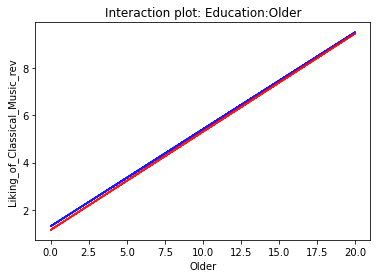

In [334]:
DV = 'Liking_of_Classical_Music_rev'
IVnumeric = 'Education'
IVbinary = 'Older'
dataframe = dgss.copy()
# dataframe = dataframe.apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
# dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, subset=(dataframe.sex!=100), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                                  OLS Regression Results                                 
Dep. Variable:     Liking_of_Classical_Music_rev   R-squared:                       0.143
Model:                                       OLS   Adj. R-squared:                  0.141
Method:                            Least Squares   F-statistic:                     84.51
Date:                           Wed, 16 Jun 2021   Prob (F-statistic):           1.41e-50
Time:                                   17:05:06   Log-Likelihood:                -2341.4
No. Observations:                           1527   AIC:                             4691.
Df Residuals:                               1523   BIC:                             4712.
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------

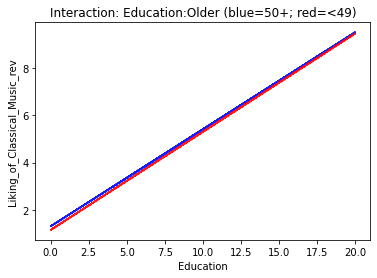

In [340]:
DV = 'Liking_of_Classical_Music_rev'
IVnumeric = 'Education'
IVbinary = 'Older'
dataframe = dgss.copy()
# dataframe = dataframe.apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
# dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, subset=(dataframe.sex!=100), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction: "+ model_fit.params.index[3]+' (blue=50+; red=<49)'); plt.xlabel(model_fit.params.index[1]); plt.ylabel(model.endog_names); plt.show()


                                  OLS Regression Results                                 
Dep. Variable:     Liking_of_Classical_Music_rev   R-squared:                       0.143
Model:                                       OLS   Adj. R-squared:                  0.141
Method:                            Least Squares   F-statistic:                     84.37
Date:                           Wed, 16 Jun 2021   Prob (F-statistic):           1.73e-50
Time:                                   16:40:02   Log-Likelihood:                -2333.3
No. Observations:                           1522   AIC:                             4675.
Df Residuals:                               1518   BIC:                             4696.
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------

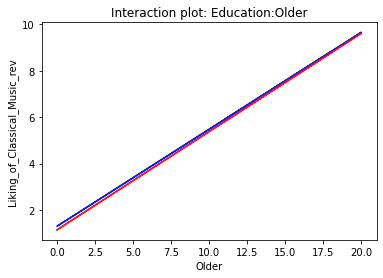

In [327]:
DV = 'Liking_of_Classical_Music_rev'
IVnumeric = 'Education'
IVbinary = 'Older'
dataframe = dgss.copy()
# dataframe = dataframe.apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
# dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, subset=(dataframe.sex!=100), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


In [ ]:
DV = 'classicl'
IVnumeric = 'educ'
IVbinary = 'Older'
dataframe = dgss.copy()
dataframe = dataframe.apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary + '+ Older + Education + Female', subset=(dataframe.country==4), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


In [222]:
# # # AREND CUSTOM (bc I personally hate downloading data files to my disk...):
# USE_GSS=True
# if USE_GSS: # I'm not using GSS data for this lab, but if we wanted to, then we could grab the data straight from a URL (demo below).
#     # try:
#     #     import gssapi
#     # except:
#     #     os.system('pip install gssapi'); import gssapi
#     from io import BytesIO
#     from zipfile import ZipFile
#     from urllib.request import urlopen # or: requests.get(url).content
#     resp = urlopen('http://gss.norc.org/documents/stata/2004_stata.zip')
#     zipfile = ZipFile(BytesIO(resp.read()))
#     dtafile = zipfile.namelist()[0]
#     print(dtafile) # ['GSS2006.dta']
#     dgss = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
# dgss

# # https://gssdataexplorer.norc.org/extracts/77613/download

GSS2004.dta


,found,occ10,occindv,occstatus,occtag,prestg10,prestg105plus,indus10,indstatus,indtag,...,yrserv5,yrserv6,yrserv7,yrserv8,yrunion4,yrvet4,yrvet5,yryouth4,yryouth5,death
0,1,NaN,0,1,1,NaN,NaN,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,NaN,0,1,1,NaN,NaN,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1,NaN,0,2,1,NaN,NaN,NaN,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1,9720.0,1,3,1,32.0,20.0,7790.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1,230.0,1,3,1,59.0,80.0,7860.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,1,120.0,1,3,1,53.0,65.0,6890.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2808,1,7140.0,1,3,1,56.0,81.0,9590.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2809,1,1740.0,1,3,1,65.0,88.0,9480.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2810,1,NaN,0,1,1,NaN,NaN,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [221]:
# pd.read_excel("/Users/rhoadss/Downloads/final_exam_python/GSSFINAL.xlsx")

In [282]:
# pd.DataFrame(dgss.value_counts())
print(sorted(dgss.columns[dgss.columns.str.contains('music|^age$|^sex$|gender$|^race|^educ$|classicl|country|married|full.*time|partfull|absingle|full')].tolist()))
print("\nage:\n", dgss.age.value_counts())
print("\neduc:\n", dgss.educ.value_counts())
dgss['Older'] = dgss.age.apply(lambda x: recode_onehot_if_greater_than(x, 49.99999))
dgss.describe()

In [ ]:
DV = 'classicl'
IVnumeric = 'educ'
IVbinary = 'Older'
dataframe = dgss.copy()
dataframe = dataframe.apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, subset=(dataframe.country==4), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               classicl   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     12.73
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           1.71e-07
Time:                        15:59:15   Log-Likelihood:                -234.30
No. Observations:                 162   AIC:                             476.6
Df Residuals:                     158   BIC:                             489.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6480      0.550      8.458      0.0

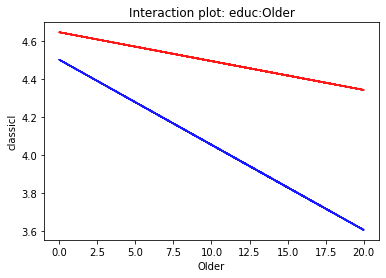

In [260]:
DV = 'classicl'
IVnumeric = 'educ'
IVbinary = 'Older'
dataframe = dgss.copy()
dataframe = dataframe.apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, subset=(dataframe.country==4), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               classicl   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     30.73
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           2.09e-18
Time:                        15:59:25   Log-Likelihood:                -841.98
No. Observations:                 567   AIC:                             1692.
Df Residuals:                     563   BIC:                             1709.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6877      0.302     15.543      0.0

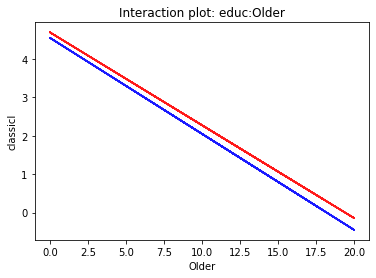

In [261]:
DV = 'classicl'
IVnumeric = 'educ'
IVbinary = 'Older'
dataframe = dgss.copy()
dataframe = dataframe.apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, subset=(dataframe.country==2), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


In [182]:
import math

In [197]:
df['fake_age'] = df.Age.apply(lambda n: 2 if math.isnan(n) else n+400 if isinstance(n, float) and round(n) in [30,32,33,34,35,36,37] else n)
df['fake_networth'] = df.NetWorth.apply(lambda n: -999999999992 if math.isnan(n) else n+400 if isinstance(n, float) and round(n) in [30,32,33,34,35,36,37] else n)
dataframe = df.copy()

                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     190.0
Date:                Wed, 16 Jun 2021   Prob (F-statistic):          6.74e-109
Time:                        15:13:05   Log-Likelihood:                -7642.5
No. Observations:                2090   AIC:                         1.529e+04
Df Residuals:                    2086   BIC:                         1.532e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.4570      0.555     24.268

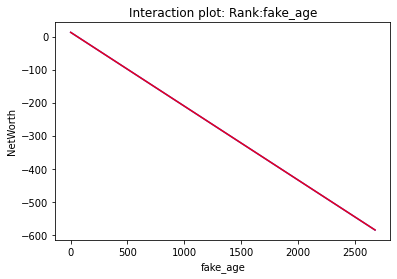

In [198]:
DV = 'NetWorth'
IVnumeric = 'Rank'
IVbinary = 'fake_age'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, subset=((dataframe['relationship_or_single']== 'In Relationship') | (dataframe['relationship_or_single']== 'Single')), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     190.0
Date:                Wed, 16 Jun 2021   Prob (F-statistic):          6.39e-109
Time:                        15:04:49   Log-Likelihood:                -7642.4
No. Observations:                2090   AIC:                         1.529e+04
Df Residuals:                    2086   BIC:                         1.532e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.3971      0.608     22.039      0.0

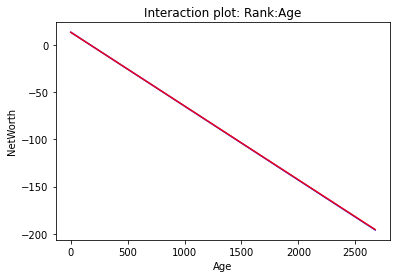

In [143]:
DV = 'NetWorth'
IVnumeric = 'Rank'
IVbinary = 'Age'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'ins')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, np.mean(dataframe[IVbinary]))) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, subset=((dataframe['relationship_or_single']== 'In Relationship') | (dataframe['relationship_or_single']== 'Single')), data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


In [52]:
# labels, uniques = pd.factorize(df.Status)

                            OLS Regression Results                            
Dep. Variable:               Children   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     19.72
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           1.52e-12
Time:                        14:46:20   Log-Likelihood:                -2905.1
No. Observations:                1544   AIC:                             5818.
Df Residuals:                    1540   BIC:                             5840.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7098      0.470      3.640      0.0

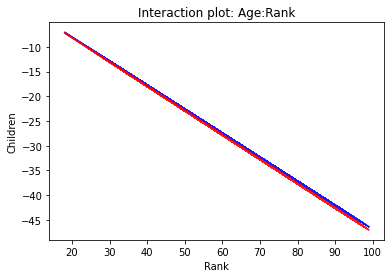

In [49]:
DV = 'Children'
IVnumeric = 'Age'
IVbinary = 'Rank'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, '9')) if y.name==IVbinary and str(y.dtype)=='object' else y.apply(lambda s: recode_onehot_if_greater_than(s, 500)) if y.name==IVbinary and str(y.dtype) in ['float64', 'int64'] else y).query(IVbinary+'==1 or '+ IVbinary+'==0')#.apply(lambda y: y.)
dataframe[DV], uniques = pd.factorize(dataframe[DV]) if not str(dataframe[DV].dtype) in ['float64', 'int64'] else dataframe[DV], dataframe[DV].unique()
model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.354
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           6.60e-05
Time:                        14:28:51   Log-Likelihood:                -9720.2
No. Observations:                2630   AIC:                         1.945e+04
Df Residuals:                    2626   BIC:                         1.947e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2808      1.120      2.037      0.0

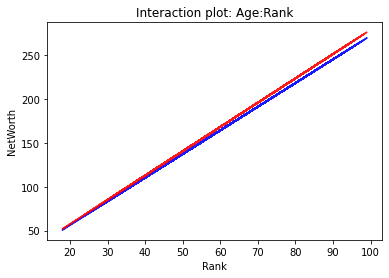

In [132]:
DV = 'NetWorth'
IVnumeric = 'Age'
IVbinary = 'Rank'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, '5')) if y.name==IVbinary else y).query(IVbinary+'==1 or '+ IVbinary+'==0')

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.235
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           0.000324
Time:                        14:28:33   Log-Likelihood:                -9721.8
No. Observations:                2630   AIC:                         1.945e+04
Df Residuals:                    2626   BIC:                         1.948e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6448      1.106      4.200      0.0

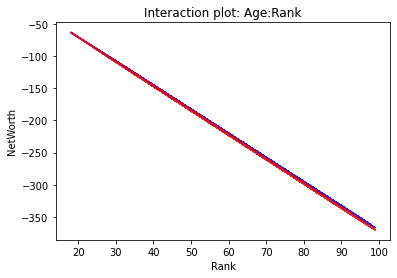

In [129]:
DV = 'NetWorth'
IVnumeric = 'Age'
IVbinary = 'Rank'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, '3')) if y.name==IVbinary else y).query(IVbinary+'==1 or '+ IVbinary+'==0')

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     13.25
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           1.39e-08
Time:                        14:28:26   Log-Likelihood:                -9711.4
No. Observations:                2630   AIC:                         1.943e+04
Df Residuals:                    2626   BIC:                         1.945e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2823      1.237      3.461      0.0

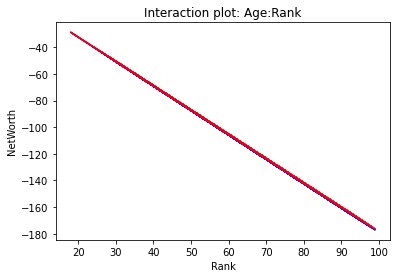

In [128]:
DV = 'NetWorth'
IVnumeric = 'Age'
IVbinary = 'Rank'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, '2')) if y.name==IVbinary else y).query(IVbinary+'==1 or '+ IVbinary+'==0')

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.173
Date:                Wed, 16 Jun 2021   Prob (F-statistic):            0.00145
Time:                        14:28:16   Log-Likelihood:                -9723.4
No. Observations:                2630   AIC:                         1.945e+04
Df Residuals:                    2626   BIC:                         1.948e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0503      1.343      2.272      0.0

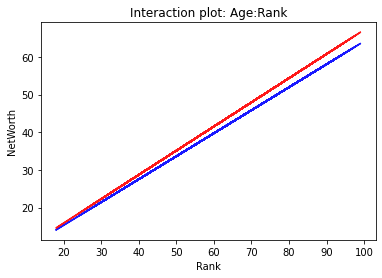

In [127]:
DV = 'NetWorth'
IVnumeric = 'Age'
IVbinary = 'Rank'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, '1')) if y.name==IVbinary else y).query(IVbinary+'==1 or '+ IVbinary+'==0')

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     268.0
Date:                Wed, 16 Jun 2021   Prob (F-statistic):          1.33e-152
Time:                        14:27:48   Log-Likelihood:                -9791.0
No. Observations:                2755   AIC:                         1.959e+04
Df Residuals:                    2751   BIC:                         1.961e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.7994      0.592     21.

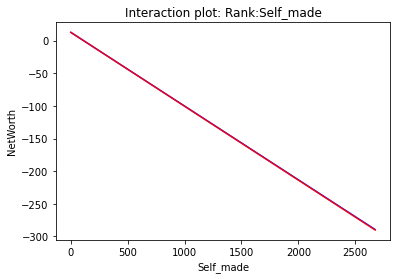

In [126]:
DV = 'NetWorth'
IVnumeric = 'Rank'
IVbinary = 'Self_made'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'True')) if y.name==IVbinary else y).query(IVbinary+'==1 or '+ IVbinary+'==0')

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     267.7
Date:                Wed, 16 Jun 2021   Prob (F-statistic):          1.98e-152
Time:                        14:27:18   Log-Likelihood:                -9791.4
No. Observations:                2755   AIC:                         1.959e+04
Df Residuals:                    2751   BIC:                         1.961e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.7152      0.332     38.

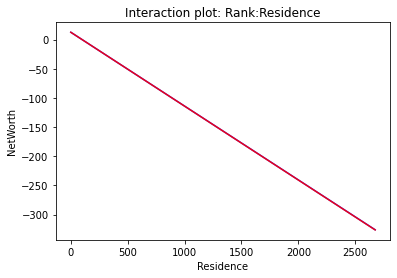

In [125]:
DV = 'NetWorth'
IVnumeric = 'Rank'
IVbinary = 'Residence'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'India')) if y.name==IVbinary else y).query(IVbinary+'==1 or '+ IVbinary+'==0')

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.348
Date:                Wed, 16 Jun 2021   Prob (F-statistic):             0.0707
Time:                        14:25:11   Log-Likelihood:                -9727.6
No. Observations:                2630   AIC:                         1.946e+04
Df Residuals:                    2626   BIC:                         1.949e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

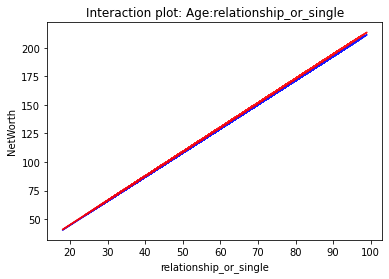

In [115]:
DV = 'NetWorth'
IVnumeric = 'Age'
IVbinary = 'relationship_or_single'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'Relationship')) if y.name==IVbinary else y).query(IVbinary+'==1 or '+ IVbinary+'==0')

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.544
Date:                Wed, 16 Jun 2021   Prob (F-statistic):              0.201
Time:                        14:26:22   Log-Likelihood:                -9728.8
No. Observations:                2630   AIC:                         1.947e+04
Df Residuals:                    2626   BIC:                         1.949e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9839      0.945      3.158      0.0

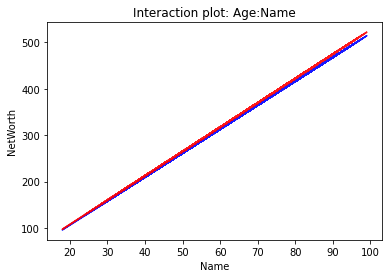

In [119]:
DV = 'NetWorth'
IVnumeric = 'Age'
IVbinary = 'Name'
dataframe = df.copy().apply(lambda y: y.apply(lambda s: recode_onehot_if(s, 'z')) if y.name==IVbinary else y).query(IVbinary+'==1 or '+ IVbinary+'==0')

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=dataframe)
model_fit = model.fit()
print(model_fit.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*1*dataframe[IVnumeric], 'b',label='1',alpha=.9) # Indep Dummy == True
plt.plot(dataframe[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * dataframe[IVnumeric] + model_fit.params[3]*0*dataframe[IVnumeric], 'r',label='2',alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


In [97]:
# df.copy().query(IVbinary+'==1')
# df.copy().query(IVbinary+'==1 or '+IVbinary+'==0')

In [ ]:
DV = 'NetWorth'
IVnumeric = 'Age'
IVbinary = 'Self_made'

model = smf.ols(formula = DV+ '~' + IVnumeric +'*'+ IVbinary, data=df)
model_fit = model.fit()
print(results.summary())
for i in range(0, len(model_fit.params)):
    print(model_fit.params.index[i], '=', round(model_fit.params[i], 4))
plt.plot(df[IVnumeric], model_fit.params[0] + model_fit.params[1] * 1+model_fit.params[2] * df[IVnumeric] + model_fit.params[3] * 1 * df[IVnumeric], 'b', label='1', alpha=.9) # Indep Dummy == True
plt.plot(df[IVnumeric], model_fit.params[0] + model_fit.params[1] * 0+model_fit.params[2] * df[IVnumeric] + model_fit.params[3] * 0 * df[IVnumeric], 'r', label='2', alpha=.9) # Indep Dummy == False
plt.title("Interaction plot: "+ model_fit.params.index[3]); plt.xlabel(model_fit.params.index[2]); plt.ylabel(model.endog_names); plt.show()


In [66]:
modsum = model
modsum

{'jb': 735210.5028997991,
 'jbpv': 0.0,
 'skew': 8.196662447916266,
 'kurtosis': 94.13255353934058,
 'omni': 2905.937511785803,
 'omnipv': 0.0,
 'condno': 1164.1442615462504,
 'mineigval': 10.437147696205985}